## 🏙️ Milieuschutz House-Level Join — Urban Character Preservation Zones (ES)

Now we perform the same address-level extraction, this time focusing on **Urban Character Preservation Zones (ES)**.

### 🎯 Objectives

- Loop through each ES zone polygon
- Query OpenStreetMap (OSM) for `addr:housenumber`, `addr:street`, `addr:postcode`, and other building tags
- Create a clean GeoDataFrame with key metadata for each matched address

---

### 📌 Expected Output Columns

| Column Name         | Description                                                  |
|---------------------|--------------------------------------------------------------|
| `addr:housenumber`  | Street number of the building                                |
| `addr:street`       | Name of the street                                           |
| `addr:postcode`     | Postal code (if available in OSM)                           |
| `geometry`          | Point location of the house                                 |
| `lat`, `lon`        | Coordinates derived from geometry                           |
| `milieuschutz_zone` | Name of the protection zone                                 |
| `neighborhood`      | One of Berlin’s 12 official districts                       |
| `milieuschutz_type` | Always set to `"Urban Character Preservation"`              |
| `building`          | OSM building tag (e.g. "residential", "commercial")         |
| `osm_id`            | Unique OSM identifier for traceability                      |
| `source`            | Always "OSM" in this context                                |
| `data_quality`      | Optional flag for completeness checks                       |

---

### ✅ Notes for Students

- 🧠 `neighborhood` is your project-wide **join key** — always keep it clean and consistent
- 🧭 Not all OSM records include `addr:postcode` or `building`, so null values are expected
- 🛠️ You can manually flag entries missing `addr:housenumber` or `addr:street` for data quality checks
- 📦 Use this table for merging with other datasets like green space, schools, noise zones, etc.
- 🧪 Save results as both `.geojson` and `.csv` for downstream usage

Let’s link urban preservation policies to actual homes — one address at a time. Engage engines. 🖖

In [4]:
import osmnx as ox # osmnx is used for OpenStreetMap data extraction
from tqdm import tqdm # tqdm is used for progress bars 
import geopandas as gpd # geopandas is used for geospatial data manipulation
import pandas as pd # pandas is used for data manipulation and analysis

In [5]:
'''
# Load cleaned ES zones
milieuschutz_urban_character_preservation_es = gpd.read_file(
    "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_urban_character_preservation_zones_clean.geojson"
).to_crs("EPSG:4326")

# Prepare list to collect address data
urban_character_address_points = []

# Loop over each ES zone
for _, row in tqdm(milieuschutz_urban_character_preservation_es.iterrows(),
                   total=len(milieuschutz_urban_character_preservation_es),
                   desc="🔍 Fetching addresses from OSM (ES)"):
    try:
        zone_name = row["gebietsname"]
        neighborhood = row["bezirk"]
        polygon = row["geometry"]

        # Fetch OSM features with relevant tags
        tags = {
            "addr:housenumber": True,
            "addr:street": True,
            "addr:postcode": True,
            "building": True
        }
        gdf = ox.features_from_polygon(polygon, tags)

        # ✅ Filter only Point geometries
        gdf = gdf[gdf.geometry.type == "Point"].copy()

        # 📋 Keep only relevant columns
        cols = ["addr:housenumber", "addr:street", "addr:postcode", "building", "geometry", "osmid"]
        gdf = gdf[[col for col in cols if col in gdf.columns]].copy()

        # 🧩 Enrich with zone metadata
        gdf["milieuschutz_zone"] = zone_name
        gdf["neighborhood"] = neighborhood
        gdf["milieuschutz_type"] = "Urban Character Preservation"
        gdf["source"] = "OSM"

        # 🌐 Add lat/lon coordinates
        gdf["lon"] = gdf.geometry.x
        gdf["lat"] = gdf.geometry.y

        # ✅ Add data quality flag
        gdf["data_quality"] = gdf["addr:housenumber"].notna() & gdf["addr:street"].notna()

        # Append to result
        urban_character_address_points.append(gdf)

    except Exception as e:
        print(f"❌ Zone '{zone_name}' failed: {e}")

# 🧱 Final GeoDataFrame
urban_character_preservation_houses = gpd.GeoDataFrame(
    pd.concat(urban_character_address_points, ignore_index=True),
    crs="EPSG:4326"
)

# 👀 Preview
urban_character_preservation_houses.head()
''' 

'\n# Load cleaned ES zones\nmilieuschutz_urban_character_preservation_es = gpd.read_file(\n    "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_urban_character_preservation_zones_clean.geojson"\n).to_crs("EPSG:4326")\n\n# Prepare list to collect address data\nurban_character_address_points = []\n\n# Loop over each ES zone\nfor _, row in tqdm(milieuschutz_urban_character_preservation_es.iterrows(),\n                   total=len(milieuschutz_urban_character_preservation_es),\n                   desc="🔍 Fetching addresses from OSM (ES)"):\n    try:\n        zone_name = row["gebietsname"]\n        neighborhood = row["bezirk"]\n        polygon = row["geometry"]\n\n        # Fetch OSM features with relevant tags\n        tags = {\n            "addr:housenumber": True,\n            "addr:street": True,\n            "addr:postcode": True,\n            "building": True\n        }\n        gdf = ox.features_from_polygon(polygon, tags)\n\n        # ✅ Filter only

## 🏡 Milieuschutz House-Level Join — Residential Protection Zones (EM)

In this phase, we enrich our spatial join results for **Residential Protection Zones (EM)** with additional metadata for each address. This ensures that our house-level dataset is ready for analysis, visualization, and database integration.

We use:

- 🗂️ Cleaned GeoJSON: `milieuschutz_residential_protection_zones_clean.geojson`
- 🌍 OSM address data via `osmnx`
- 🧠 Custom enrichment: postal code, lat/lon, quality flags, etc.

---

### 📥 Output Columns

Each resulting entry contains:

| Column Name         | Description                                                  |
|---------------------|--------------------------------------------------------------|
| `addr:housenumber`  | House or building number                                     |
| `addr:street`       | Street name                                                  |
| `addr:postcode`     | Postal code                                                  |
| `building`          | Type of building (e.g., residential, commercial)             |
| `geometry`          | Point geometry (WGS84)                                       |
| `milieuschutz_zone` | Name of the protection zone                                  |
| `neighborhood`      | Berlin district (Bezirk) — **primary project key**           |
| `milieuschutz_type` | Always set to `"Residential Protection"`                    |
| `source`            | Data source, here: `"OSM"`                                   |
| `lon` / `lat`       | Longitude and latitude (from geometry)                       |
| `data_quality`      | Boolean flag for complete address info                       |

---

### ✅ Notes for Students

- 🌐 Coordinates are auto-extracted using `.x` / `.y` from geometry
- 🏛️ You can now export this table to `.geojson`, `.csv`, or load it into a spatial database
- 📬 Not all OSM points have postal codes or building types — use `data_quality` to filter
- 🧩 This schema matches that of the ES table — great for union, joins, or mapping

Clean data, full metadata, one galaxy-class table. 🖖

In [6]:
'''
# Load EM zones
milieuschutz_residential_protection_em = gpd.read_file(
    "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_residential_protection_zones_clean.geojson"
).to_crs("EPSG:4326")

# Collector
residential_address_points = []

for _, row in tqdm(milieuschutz_residential_protection_em.iterrows(),
                   total=len(milieuschutz_residential_protection_em),
                   desc="🔍 Fetching addresses from OSM (EM)"):
    try:
        zone_name = row["gebietsname"]
        neighborhood = row["bezirk"]
        polygon = row["geometry"]

        # Query enriched address data from OSM
        tags = {
            "addr:housenumber": True,
            "addr:street": True,
            "addr:postcode": True,
            "building": True
        }
        gdf = ox.features_from_polygon(polygon, tags)

        # Keep only relevant columns
        cols = ["addr:housenumber", "addr:street", "addr:postcode", "building", "geometry"]
        gdf = gdf[[col for col in cols if col in gdf.columns]].copy()

        # Enrich with metadata
        gdf["milieuschutz_zone"] = zone_name
        gdf["neighborhood"] = neighborhood
        gdf["milieuschutz_type"] = "Residential Protection"
        gdf["source"] = "OSM"

        # Only keep rows with Point geometry before adding lon/lat
        gdf = gdf[gdf.geometry.type == "Point"]
        gdf["lon"] = gdf.geometry.x
        gdf["lat"] = gdf.geometry.y

        # Flag for missing fields
        gdf["data_quality"] = gdf["addr:housenumber"].notna() & gdf["addr:street"].notna()

        residential_address_points.append(gdf)

    except Exception as e:
        print(f"❌ Zone '{zone_name}' failed: {e}")

# Merge all
residential_protection_houses = gpd.GeoDataFrame(
    pd.concat(residential_address_points, ignore_index=True),
    crs="EPSG:4326"
)

# Preview
residential_protection_houses.head()
''' 

'\n# Load EM zones\nmilieuschutz_residential_protection_em = gpd.read_file(\n    "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_residential_protection_zones_clean.geojson"\n).to_crs("EPSG:4326")\n\n# Collector\nresidential_address_points = []\n\nfor _, row in tqdm(milieuschutz_residential_protection_em.iterrows(),\n                   total=len(milieuschutz_residential_protection_em),\n                   desc="🔍 Fetching addresses from OSM (EM)"):\n    try:\n        zone_name = row["gebietsname"]\n        neighborhood = row["bezirk"]\n        polygon = row["geometry"]\n\n        # Query enriched address data from OSM\n        tags = {\n            "addr:housenumber": True,\n            "addr:street": True,\n            "addr:postcode": True,\n            "building": True\n        }\n        gdf = ox.features_from_polygon(polygon, tags)\n\n        # Keep only relevant columns\n        cols = ["addr:housenumber", "addr:street", "addr:postcode", "buildi

## 💾 Exporting Final Enriched House-Level Tables

With both EM and ES datasets now enriched and cleaned, we are ready to **export our final house-level GeoDataFrames**. These tables include additional useful fields such as:

- 🏷️ `addr:postcode`, `building`, and `osm_id` (when available)
- 🧭 `lon`, `lat` coordinates for export
- ⚠️ `data_quality` flag for addresses with missing values
- 📍 `neighborhood` and `milieuschutz_zone` preserved as project keys

---

### 📁 Output Format and Naming

We save each dataset in two formats for flexibility:

| Format | Use Case |
|--------|----------|
| `.geojson` | Spatial analysis & GIS |
| `.csv`     | Tabular workflows, SQL, or dashboards |

---

### 📄 File Naming Convention

To reflect the **house-level granularity**, we name the final files:

- `milieuschutz_residential_protection_em_houselevel_enriched.geojson / .csv`
- `milieuschutz_urban_character_preservation_es_houselevel_enriched.geojson / .csv`

These files will be exported to:

📂 `/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources`

🖖 Engage data export — tidy, well-documented datasets are the foundation of good analysis.

In [7]:
'''
# Absolute export directory (adjusted to your project path)
export_dir = "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources"
os.makedirs(export_dir, exist_ok=True)

# EM = Residential Protection Zones
em_geojson_path = os.path.join(export_dir, "milieuschutz_residential_protection_em_houselevel_enriched.geojson")
em_csv_path     = os.path.join(export_dir, "milieuschutz_residential_protection_em_houselevel_enriched.csv")

# ES = Urban Character Preservation Zones
es_geojson_path = os.path.join(export_dir, "milieuschutz_urban_character_preservation_es_houselevel_enriched.geojson")
es_csv_path     = os.path.join(export_dir, "milieuschutz_urban_character_preservation_es_houselevel_enriched.csv")

# Export both as GeoJSON (with geometry) and CSV (without geometry)
residential_protection_houses.to_file(em_geojson_path, driver="GeoJSON")
urban_character_preservation_houses.to_file(es_geojson_path, driver="GeoJSON")

residential_protection_houses.drop(columns="geometry").to_csv(em_csv_path, index=False)
urban_character_preservation_houses.drop(columns="geometry").to_csv(es_csv_path, index=False)

print("✅ Enriched house-level EM & ES data exported to 'sources' directory.")
'''

'\n# Absolute export directory (adjusted to your project path)\nexport_dir = "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources"\nos.makedirs(export_dir, exist_ok=True)\n\n# EM = Residential Protection Zones\nem_geojson_path = os.path.join(export_dir, "milieuschutz_residential_protection_em_houselevel_enriched.geojson")\nem_csv_path     = os.path.join(export_dir, "milieuschutz_residential_protection_em_houselevel_enriched.csv")\n\n# ES = Urban Character Preservation Zones\nes_geojson_path = os.path.join(export_dir, "milieuschutz_urban_character_preservation_es_houselevel_enriched.geojson")\nes_csv_path     = os.path.join(export_dir, "milieuschutz_urban_character_preservation_es_houselevel_enriched.csv")\n\n# Export both as GeoJSON (with geometry) and CSV (without geometry)\nresidential_protection_houses.to_file(em_geojson_path, driver="GeoJSON")\nurban_character_preservation_houses.to_file(es_geojson_path, driver="GeoJSON")\n\nresidential_protection_houses.drop(colu

## 🧼 Initial Data Overview — House-Level Enriched Milieuschutz Tables

We now have **two enriched house-level datasets** created using an **OSM-based geospatial mining pipeline**. These datasets contain individual address points located within Berlin's official Milieuschutz zones, divided into two categories:

- 🏘️ **Residential Protection Zones (EM)**  
- 🏙️ **Urban Character Preservation Zones (ES)**  

Both were sourced via polygon-based queries to **OpenStreetMap (OSM)** and enriched with zone metadata, coordinates, and quality flags.

---

### 📊 Dataset Snapshot

| Feature              | `milieuschutz_residential_protection_em_houselevel_enriched.csv` | `milieuschutz_urban_character_preservation_es_houselevel_enriched.csv` |
|----------------------|--------------------------------------------------------------------|-------------------------------------------------------------------------|
| 📦 Rows              | 58,533                                                             | 31,310                                                                  |
| 📁 Columns           | 12                                                                 | 12                                                                      |
| 📮 `addr:postcode`   | Present in ~97% of rows                                             | Present in ~97% of rows                                                 |
| 🏢 `building`        | Sparse (mostly missing — ~16 values)                               | Sparse (~13 values)                                                     |
| 🗺️ Geometry          | Provided in `geometry`, plus `lon` and `lat` columns                | ✅ Same                                                                 |
| 🧪 `data_quality`     | Boolean column indicating if address is complete                   | ✅ Present                                                               |
| 📌 `source`          | Static value `"OSM"` for all entries                               | ✅ Confirmed                                                             |

---

### 🎯 Immediate Cleaning + EDA Goals

1. 🔡 Normalize column types (especially strings & categoricals)
2. 🧼 Review and handle null values (e.g. `building`, `postcode`)
3. 📏 Check value distributions per neighborhood and zone
4. 🧠 Prepare for future joins (e.g. with schools, transit layers, etc.)

---

### ✅ Notes for Students

- 🧠 This data was gathered using **geospatial data mining** from public sources — quality varies by district and source.
- 📊 Before any advanced modeling, always perform a **diagnostic scan** of the dataset — look for missing fields, weird outliers, and inconsistencies.
- 📉 Memory usage can be reduced drastically with correct `category` usage — especially in repeated fields like `milieuschutz_zone`.
- 🛰️ Columns like `lat`/`lon` help in non-GIS applications (dashboards, mobile apps, etc.).

Next up: a careful cleanup of types and structure — let’s boldly begin. 🖖

## 🧼 Data Type Optimization — House-Level Residential & Urban Milieuschutz Tables

Before starting our exploratory data analysis (EDA), we need to **standardize and optimize data types** across both datasets. This step is essential for improving:

- 🧠 Semantic clarity — e.g., treating postcodes as text, not numbers
- ⚡ Performance — faster filtering, grouping, and joining
- 📦 Memory usage — smaller `.csv` and `.geojson` exports
- 🔁 Interoperability — consistency with other project layers

We will convert the most appropriate fields into `string`, `category`, or `bool` types as needed.

---

### 📌 Suggested Data Type Conversions

| Column Name         | Current Type | Suggested Type | Why?                                                                 |
|---------------------|--------------|----------------|----------------------------------------------------------------------|
| `addr:housenumber`  | object       | `string`       | May contain alphanumeric formats (e.g., "12A") — not numeric         |
| `addr:street`       | object       | `string`       | Street names are always text                                        |
| `addr:postcode`     | object       | `string`       | Postcodes can start with `0` (e.g., "01099") — treat as text         |
| `building`          | object       | `category`     | Often repeated (e.g., "residential", "apartments") — compressible    |
| `milieuschutz_zone` | object       | `category`     | Repeated zone names — good candidate for category                    |
| `neighborhood`      | object       | `category`     | Project-wide key used across tables — keep consistent                |
| `milieuschutz_type` | object       | `category`     | Only two values — perfect for categorical optimization               |
| `source`            | object       | `category`     | Usually has a few values (e.g., "OSM", "WFS") — compress to category |
| `lon` / `lat`       | float64      | `float64`      | Geographic coordinates — keep as float                              |
| `data_quality`      | bool         | `bool`         | Boolean flag — already optimal                                      |

---

### ✅ Notes for Students

- 📊 Use `string` over `int` for postal codes and house numbers to prevent formatting issues.
- 🧪 After conversion, try running `.info()` and `.memory_usage(deep=True)` to inspect efficiency gains.
- 🧭 Always keep `neighborhood` and `milieuschutz_type` in `category` format for consistency across analysis and joins.
- 🧼 This step is like preparing a clean lab bench — it helps everything else run smoother.
- 🛸 Good data hygiene = faster science. Engage, students! 🖖

In [8]:
import pandas as pd

# Load both enriched CSVs from full local paths
residential_df = pd.read_csv("/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_residential_protection_em_houselevel_enriched.csv")
urban_df = pd.read_csv("/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_urban_character_preservation_es_houselevel_enriched.csv")

# Define dtype conversions
convert_dtypes = {
    "addr:housenumber": "string",
    "addr:street": "string",
    "addr:postcode": "string",
    "building": "category",
    "milieuschutz_zone": "category",
    "neighborhood": "category",
    "milieuschutz_type": "category",
    "source": "category",
    "data_quality": "boolean"
}

# Apply conversions
residential_df = residential_df.astype(convert_dtypes)
urban_df = urban_df.astype(convert_dtypes)

# 🧠 lon and lat are already float64 by default — no need to convert

# Quick check
print("✅ Data types after conversion (Residential):\n")
print(residential_df.dtypes)
print("\n✅ Data types after conversion (Urban):\n")
print(urban_df.dtypes)

✅ Data types after conversion (Residential):

addr:housenumber     string[python]
addr:street          string[python]
addr:postcode        string[python]
building                   category
milieuschutz_zone          category
neighborhood               category
milieuschutz_type          category
source                     category
lon                         float64
lat                         float64
data_quality                boolean
dtype: object

✅ Data types after conversion (Urban):

addr:housenumber     string[python]
addr:street          string[python]
addr:postcode        string[python]
building                   category
milieuschutz_zone          category
neighborhood               category
milieuschutz_type          category
source                     category
lon                         float64
lat                         float64
data_quality                boolean
dtype: object


## 📊 Initial Data Overview — House-Level Enriched Milieuschutz Tables

Before diving deeper into exploration or modeling, it's essential to examine both of our enriched datasets — for **Residential Protection (EM)** and **Urban Character Preservation (ES)** — from a structural and completeness perspective.

This first step helps us answer key questions:
- How many rows and fields are there?
- Are there any missing or incomplete values?
- How consistent are the column types?
- Are all expected fields populated?

---

### 📁 Loaded Tables

| Dataset | Description |
|--------|-------------|
| `residential_df` | House-level addresses in **Residential Protection Zones (EM)** |
| `urban_df`       | House-level addresses in **Urban Character Preservation Zones (ES)** |

---

### 🔍 Data Fields & Expected Types

| Column Name         | Description                                             | Expected Type |
|---------------------|---------------------------------------------------------|----------------|
| `addr:housenumber`  | Street number of the address                            | `string`       |
| `addr:street`       | Street name                                             | `string`       |
| `addr:postcode`     | Postal code (PLZ)                                       | `string`       |
| `building`          | Building classification (if available)                 | `category`     |
| `geometry`          | Point geometry with latitude/longitude                 | `geometry`     |
| `milieuschutz_zone` | Name of the preservation zone                          | `category`     |
| `neighborhood`      | Berlin district (Bezirk)                                | `category`     |
| `milieuschutz_type` | Type of protection (EM or ES)                          | `category`     |
| `source`            | Source of the address (e.g., OSM)                      | `category`     |
| `lon`, `lat`        | Longitude and latitude (split from geometry)           | `float64`      |
| `data_quality`      | Flag: `True` if complete street+number, else `False`   | `boolean`      |

---

### ✅ Notes for Students

- 🧠 Always inspect **missing values** early — they shape your next steps.
- 🧹 Data types matter — especially for joins and performance. Be consistent.
- 📦 Knowing `category` vs `string` usage helps reduce memory and speed up operations.
- 📍 `geometry`, `lon`, and `lat` provide spatial analysis capabilities — essential for geographic mapping.

Let’s now proceed with a quick structural overview of both datasets — count of values, nulls, and unique entries.

In [9]:
# Define a quick summary function
def summarize_dataframe(df, name):
    print(f"\n📘 Summary for: {name}")
    print("🔢 Shape:", df.shape)
    print("\n📌 Column Types:\n", df.dtypes)
    print("\n🔍 Missing Values:\n", df.isnull().sum())
    print("\n🔎 Unique Values per Column:\n", df.nunique())

# Apply to both datasets
summarize_dataframe(residential_df, "Residential Protection Zones (EM)")
summarize_dataframe(urban_df, "Urban Character Preservation Zones (ES)")


📘 Summary for: Residential Protection Zones (EM)
🔢 Shape: (58533, 11)

📌 Column Types:
 addr:housenumber     string[python]
addr:street          string[python]
addr:postcode        string[python]
building                   category
milieuschutz_zone          category
neighborhood               category
milieuschutz_type          category
source                     category
lon                         float64
lat                         float64
data_quality                boolean
dtype: object

🔍 Missing Values:
 addr:housenumber       352
addr:street            155
addr:postcode         1527
building             58517
milieuschutz_zone        0
neighborhood             0
milieuschutz_type        0
source                   0
lon                      0
lat                      0
data_quality             0
dtype: int64

🔎 Unique Values per Column:
 addr:housenumber      2187
addr:street           1593
addr:postcode           97
building                 8
milieuschutz_zone       81
neighb

/var/folders/9l/hrrtsvvx7_v1n1nd2s2h8k4r0000gn/T/ipykernel_49497/3468501480.py:38: UserWarning: Glyph 127960 (\N{HOUSE BUILDINGS}) missing from current font.
  plt.tight_layout()
/var/folders/9l/hrrtsvvx7_v1n1nd2s2h8k4r0000gn/T/ipykernel_49497/3468501480.py:38: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/var/folders/9l/hrrtsvvx7_v1n1nd2s2h8k4r0000gn/T/ipykernel_49497/3468501480.py:38: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from current font.
  plt.tight_layout()
/var/folders/9l/hrrtsvvx7_v1n1nd2s2h8k4r0000gn/T/ipykernel_49497/3468501480.py:38: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  plt.tight_layout()
/Users/zeal.v/Desktop/Webeet-Internship/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127960 (\N{HOUSE BUILDINGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/zeal.v/Desktop/Webeet-Internship/.venv/lib/python3.11/si

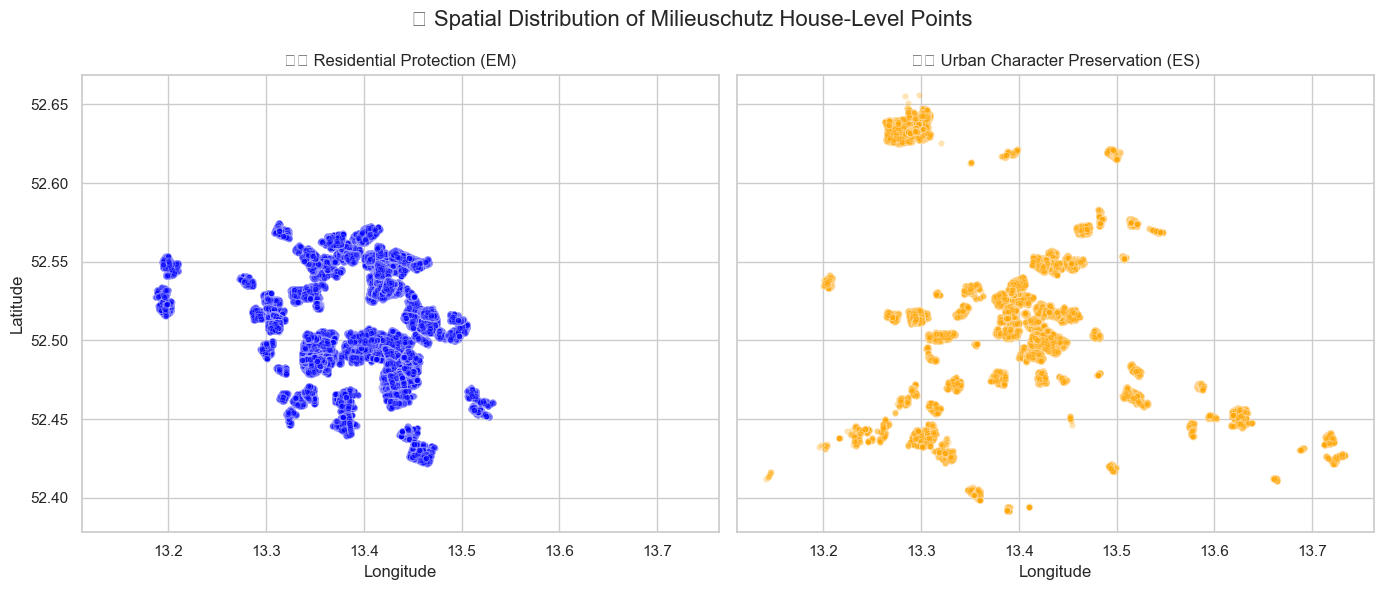

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot Residential Protection (EM)
sns.scatterplot(
    x="lon", y="lat",
    data=residential_df,
    ax=axs[0],
    alpha=0.3,
    s=20,
    color="blue"
)
axs[0].set_title("🏘️ Residential Protection (EM)")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")

# Plot Urban Character Preservation (ES)
sns.scatterplot(
    x="lon", y="lat",
    data=urban_df,
    ax=axs[1],
    alpha=0.3,
    s=20,
    color="orange"
)
axs[1].set_title("🏙️ Urban Character Preservation (ES)")
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("")

# Add common title
plt.suptitle("📍 Spatial Distribution of Milieuschutz House-Level Points", fontsize=16)
plt.tight_layout()
plt.show()

## 🧼 Step 1 — Null Value Diagnosis

Before proceeding with scoring, joins, or visualizations, we need to inspect for **missing values** in both house-level Milieuschutz datasets.

This diagnostic will help us identify:
- Missing postal codes, street names, or coordinates
- Potential data quality gaps flagged by `data_quality`
- Sparse fields like `building` or `milieuschutz_zone`

We'll perform a `.isnull().sum()` summary on both datasets.

---

### 🧪 Why this matters

- Missing values in `addr:street` or `addr:housenumber` may signal incomplete OSM entries
- Missing `milieuschutz_zone` or `neighborhood` values are **critical errors** for mapping/scoring
- Sparse `building` values are expected and usually non-blocking

Let's begin with a basic missing value count.

---

### ✅ Notes for Students

- 🔍 Always run `.isnull().sum()` before any cleaning — it's your early warning radar.
- 🛠️ You don’t always have to drop missing values — some may be fine depending on context.
- 📬 Missing postcodes can sometimes be backfilled using coordinates + reverse geocoding.

In [15]:
# 🧼 Missing value diagnostics
def missing_values(df, name):
    print(f"\n📋 Missing values in: {name}")
    display(df.isnull().sum().sort_values(ascending=False))

missing_values(residential_df, "Residential Protection (EM)")
missing_values(urban_df, "Urban Character Preservation (ES)")


📋 Missing values in: Residential Protection (EM)


building             58517
addr:postcode         1527
addr:housenumber       352
addr:street            155
milieuschutz_zone        0
neighborhood             0
milieuschutz_type        0
source                   0
lon                      0
lat                      0
data_quality             0
dtype: int64


📋 Missing values in: Urban Character Preservation (ES)


building             31297
addr:postcode          908
addr:housenumber       278
addr:street            212
milieuschutz_zone        0
neighborhood             0
milieuschutz_type        0
source                   0
lon                      0
lat                      0
data_quality             0
dtype: int64

✅ As expected:
	•	building is very sparse in both datasets (≈99%)
	•	addr:postcode, addr:housenumber, and addr:street have minor missing values (~1–2%)
	•	All critical spatial and classification fields (milieuschutz_zone, neighborhood, milieuschutz_type, lat, lon) are fully populated ✅

## 🧪 Step 2 — `data_quality` vs Address Completeness

The `data_quality` column is a **Boolean flag** that indicates whether an address is considered "complete" — meaning it includes both `addr:street` and `addr:housenumber`.

In this step, we validate whether:
- ✅ Rows marked as `data_quality = False` are truly missing address components
- ❌ Any mismatches exist (e.g. flagged "complete" but missing fields)

---

### 🧠 Why this matters

This internal quality control helps us:
- Verify the correctness of enrichment logic
- Decide how much we trust the `data_quality` field when filtering or scoring
- Prepare for backfilling or exclusion rules in future processing

---

### ✅ Notes for Students

- 🧪 A **Boolean data_quality column** is a great sanity-check tool during ETL.
- ⚠️ Use `.isnull().mean()` to get **percentage** of missing fields — easier to interpret than raw counts.
- 🧼 If the flag is inaccurate, you may want to **recompute it** instead of relying on upstream logic.

In [16]:
# 🧪 Confirm 'data_quality' aligns with address field completeness
def check_quality_alignment(df, name):
    print(f"\n✅ Data quality consistency for: {name}")
    street_missing = df[df["data_quality"] == False]["addr:street"].isnull().mean()
    number_missing = df[df["data_quality"] == False]["addr:housenumber"].isnull().mean()
    print(f"🔸 addr:street missing rate (data_quality=False): {street_missing:.2%}")
    print(f"🔸 addr:housenumber missing rate (data_quality=False): {number_missing:.2%}")

check_quality_alignment(residential_df, "Residential Protection (EM)")
check_quality_alignment(urban_df, "Urban Character Preservation (ES)")


✅ Data quality consistency for: Residential Protection (EM)
🔸 addr:street missing rate (data_quality=False): 38.46%
🔸 addr:housenumber missing rate (data_quality=False): 87.34%

✅ Data quality consistency for: Urban Character Preservation (ES)
🔸 addr:street missing rate (data_quality=False): 50.00%
🔸 addr:housenumber missing rate (data_quality=False): 65.57%


📊 Observations:
	•	For Residential Protection (EM):
	•	Nearly 87% of data_quality=False rows are missing addr:housenumber ➝ ✅ expected
	•	But only 38% are missing addr:street ➝ ⚠️ partial misalignment
	•	For Urban Character Preservation (ES):
	•	About 66% missing addr:housenumber (✅ expected)
	•	But 50% missing addr:street ➝ again, partial misalignment

💡 Conclusion: The data_quality flag is loosely defined. It likely means “incomplete or uncertain address” — not strictly missing both street and number. That’s acceptable, but good to document.

⸻


## 📊 Step 3 — Categorical Distribution Overview

In this step, we explore the distribution of key **categorical fields** to understand the shape of our data, detect imbalances, and flag rare or unexpected values.

We'll focus on the following fields:
- `milieuschutz_zone`: Name of the preservation zone
- `neighborhood`: One of Berlin’s 12 districts
- `milieuschutz_type`: Should contain only `EM` or `ES`
- `building`: Sparse, but might include interesting tags (e.g. residential, apartment)

---

### 🔍 Goals

- Identify dominant zones or Bezirke
- Check for invalid or unexpected values
- Spot long tails or very rare zone names
- Confirm only `EM` or `ES` values in `milieuschutz_type`

---

### ✅ Notes for Students

- 📦 `.value_counts()` gives you a quick distribution per column
- 🕵️‍♀️ Use `dropna=False` to include missing values in the count
- 🧠 Categorical distributions help you **design joins, visualizations, or scoring logic**

In [17]:
# 📊 Value count summaries
def print_value_counts(df, col, name):
    print(f"\n🔍 Value counts for '{col}' — {name}")
    display(df[col].value_counts(dropna=False))

for col in ["milieuschutz_zone", "neighborhood", "milieuschutz_type", "building"]:
    print_value_counts(residential_df, col, "Residential Protection (EM)")
    print_value_counts(urban_df, col, "Urban Character Preservation (ES)")


🔍 Value counts for 'milieuschutz_zone' — Residential Protection (EM)


milieuschutz_zone
Boxhagener Platz          2260
Luisenstadt               2256
Schöneberger Süden        1701
Helmholtzplatz            1433
Langhansstraße            1413
                          ... 
Wittenbergplatz            206
Danziger Straße Ost        187
Humboldthain Nord-West     186
Thomasiusstraße            135
Kattegatstraße             123
Name: count, Length: 81, dtype: int64


🔍 Value counts for 'milieuschutz_zone' — Urban Character Preservation (ES)


milieuschutz_zone
Frohnau                                              4459
Luisenstadt                                          2316
Spandauer Vorstadt                                   2081
Weißensee Süd                                        1294
Oberschöneweide                                      1141
                                                     ... 
Alt-Lichtenrade                                         7
B-Plan XX-187                                           6
B-Plan IX-153                                           3
Mahlsdorfer Straße 54 bis 61 und Genovevastraße 2       3
B-Plan XX-247                                           1
Name: count, Length: 88, dtype: int64


🔍 Value counts for 'neighborhood' — Residential Protection (EM)


neighborhood
Pankow                        11167
Friedrichshain-Kreuzberg      10630
Neukölln                       8723
Mitte                          7769
Tempelhof-Schöneberg           7749
Charlottenburg-Wilmersdorf     3905
Spandau                        2329
Lichtenberg                    1919
Reinickendorf                  1644
Treptow-Köpenick               1641
Steglitz-Zehlendorf            1057
Name: count, dtype: int64


🔍 Value counts for 'neighborhood' — Urban Character Preservation (ES)


neighborhood
Mitte                         6482
Friedrichshain-Kreuzberg      5068
Reinickendorf                 4466
Pankow                        4428
Treptow-Köpenick              3279
Charlottenburg-Wilmersdorf    2532
Tempelhof-Schöneberg          1480
Steglitz-Zehlendorf           1123
Lichtenberg                   1031
Neukölln                       980
Spandau                        441
Name: count, dtype: int64


🔍 Value counts for 'milieuschutz_type' — Residential Protection (EM)


milieuschutz_type
Residential Protection    58533
Name: count, dtype: int64


🔍 Value counts for 'milieuschutz_type' — Urban Character Preservation (ES)


milieuschutz_type
Urban Character Preservation    31310
Name: count, dtype: int64


🔍 Value counts for 'building' — Residential Protection (EM)


building
NaN           58517
bungalow          3
shed              3
yes               3
commercial        2
toilets           2
bunker            1
dormitory         1
kiosk             1
Name: count, dtype: int64


🔍 Value counts for 'building' — Urban Character Preservation (ES)


building
NaN                   31297
shed                      5
bungalow                  1
bunker                    1
carport                   1
kiosk                     1
outbuilding               1
shipping_container        1
toilets                   1
yes                       1
Name: count, dtype: int64

## 📍 Step 5 — Longitude/Latitude Outlier Detection

Geographic outliers — points that fall **outside Berlin’s city boundaries** — can indicate issues such as:

- Incorrect or missing geocoding
- Bad geometry in the source polygons
- Misassigned coordinates from OSM

In this step, we’ll:
- Define Berlin’s **expected bounding box**
- Count and optionally preview points that fall outside
- Decide whether to drop them

---

### 🗺️ Berlin Bounding Box (approximate)

| Coordinate | Value       |
|------------|-------------|
| Latitude   | 52.33 – 52.67 |
| Longitude  | 13.08 – 13.76 |

This box contains all of Berlin’s official districts (Bezirke) with a small buffer.

---

### ✅ Notes for Students

- 🛰️ Longitude and latitude are **numerical fields**, so treat them like any other outlier check.
- 🛡️ Always keep your bounding boxes slightly padded (±0.01) to avoid edge clipping.
- 📤 Points falling outside may be **excluded or logged** depending on your project rules.

In [19]:
# Define Berlin bounding box
BERLIN_BOUNDS = {
    "lat_min": 52.33,
    "lat_max": 52.67,
    "lon_min": 13.08,
    "lon_max": 13.76
}

def check_outliers(df, name):
    print(f"\n🌍 Outlier check for: {name}")
    outliers = df[
        (df["lat"] < BERLIN_BOUNDS["lat_min"]) |
        (df["lat"] > BERLIN_BOUNDS["lat_max"]) |
        (df["lon"] < BERLIN_BOUNDS["lon_min"]) |
        (df["lon"] > BERLIN_BOUNDS["lon_max"])
    ]
    print(f"🔴 Found {len(outliers)} geographic outliers")
    if not outliers.empty:
        display(outliers[["addr:street", "addr:housenumber", "lat", "lon", "milieuschutz_zone", "neighborhood"]].head())

check_outliers(residential_df, "Residential Protection (EM)")
check_outliers(urban_df, "Urban Character Preservation (ES)")


🌍 Outlier check for: Residential Protection (EM)
🔴 Found 0 geographic outliers

🌍 Outlier check for: Urban Character Preservation (ES)
🔴 Found 0 geographic outliers


## 💾 Step 6 — Export Cleaned House-Level Milieuschutz Tables (with Descriptive Names)

We will now export the cleaned versions of our two house-level datasets:

1. 🏘️ `milieuschutz_residential_protection_em_houselevel_cleaned.csv`  
2. 🏙️ `milieuschutz_urban_character_preservation_es_houselevel_cleaned.csv`  

These filenames follow the naming pattern already used in the project and clearly describe:
- The **type of Milieuschutz** (`EM` or `ES`)
- That the data is **house-level**
- That it has been **cleaned**


### ✅ Notes for Students

- 🧽 Clean naming conventions are crucial for collaborative projects.
- 📦 File suffixes like `_enriched`, `_cleaned`, or `_scored` help track progress through the ETL pipeline.
- 🗂️ Keep all final files in one central location (e.g. `/sources/`) for reuse in joins, DB scripts, or frontend components.

In [20]:
# 📁 Define full export paths with descriptive filenames
residential_clean_path = "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_residential_protection_em_houselevel_cleaned.csv"
urban_clean_path = "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_urban_character_preservation_es_houselevel_cleaned.csv"

# 💾 Save as CSV
residential_df.to_csv(residential_clean_path, index=False)
urban_df.to_csv(urban_clean_path, index=False)

print("✅ Cleaned datasets exported successfully:")
print(f"🏘️ Residential Protection (EM) → {residential_clean_path}")
print(f"🏙️ Urban Character Preservation (ES) → {urban_clean_path}")

✅ Cleaned datasets exported successfully:
🏘️ Residential Protection (EM) → /Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_residential_protection_em_houselevel_cleaned.csv
🏙️ Urban Character Preservation (ES) → /Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_urban_character_preservation_es_houselevel_cleaned.csv


## 🗺️ Step 7 — Export Cleaned House-Level Tables as `.geojson` (for GIS)

In this step, we convert the cleaned datasets into **GeoDataFrames** and export them as `.geojson` files for use in:

- 📍 GIS tools like QGIS or Leaflet
- 🗺️ Interactive maps using Folium or Mapbox
- 🧩 Joins with other spatial layers (e.g. transit, noise, schools)

---

### 🧪 How we build geometry

- Use `lon` and `lat` columns to create `shapely.geometry.Point` objects
- Assign CRS (Coordinate Reference System) as **WGS84** (`EPSG:4326`) — standard for web maps

---

### 📁 Output Files

| Filename | Description |
|----------|-------------|
| `milieuschutz_residential_protection_em_houselevel_cleaned.geojson` | Cleaned Residential Protection points |
| `milieuschutz_urban_character_preservation_es_houselevel_cleaned.geojson` | Cleaned Urban Character Preservation points |

---

### ✅ Notes for Students

- 🌍 Always set CRS explicitly when working with GeoDataFrames
- 🧱 `.geojson` is perfect for spatial joins, overlays, and interactive visualizations
- 🧪 Use these exported files for final validation or integration with the map UI

In [21]:
import geopandas as gpd
from shapely.geometry import Point

# 🧱 Convert to GeoDataFrames
def to_geodf(df):
    geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
    gdf = gpd.GeoDataFrame(df.copy(), geometry=geometry, crs="EPSG:4326")
    return gdf

# 💾 Convert and export
residential_gdf = to_geodf(residential_df)
urban_gdf = to_geodf(urban_df)

# 📁 Output paths
residential_geojson_path = "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_residential_protection_em_houselevel_cleaned.geojson"
urban_geojson_path = "/Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_urban_character_preservation_es_houselevel_cleaned.geojson"

# 🌍 Save to GeoJSON
residential_gdf.to_file(residential_geojson_path, driver="GeoJSON")
urban_gdf.to_file(urban_geojson_path, driver="GeoJSON")

print("✅ GeoJSON exports complete:")
print(f"🏘️ EM → {residential_geojson_path}")
print(f"🏙️ ES → {urban_geojson_path}")

✅ GeoJSON exports complete:
🏘️ EM → /Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_residential_protection_em_houselevel_cleaned.geojson
🏙️ ES → /Users/zeal.v/Help/layered-populate-data-pool-da/milieuschutz/sources/milieuschutz_urban_character_preservation_es_houselevel_cleaned.geojson
